# Neural Agent Memory Analysis

This notebook analyzes the training memory of a neural agent to understand its performance and behavior over time. It loads the agent's memory, calculates win rates, and visualizes action distributions.

In [10]:
# Import necessary libraries
from pathlib import Path
import pickle
import numpy as np
from typing import List, Tuple

# Assuming src is in the python path or adjust sys.path if needed
import sys
sys.path.append('../') # Example if running from notebooks dir

from src.engine.actions import Action
from src.analysis.memory_analyzer import analyze_win_loss_and_steps, calculate_win_rate_over_time, analyze_and_plot_win_rates_by_starting_position

In [11]:
from src.analysis.memory_loader import load_memory
from src.analysis.action_analyzer import analyze_actions

# Get the user's home directory
home_dir = Path.home()

# Construct the path to the Downloads folder (or wherever your memory file is)
downloads_dir = home_dir / "Downloads"

# Find the most recently updated .pkl file in the Downloads folder
pkl_files = list(downloads_dir.glob("*.pkl"))
if not pkl_files:
    raise FileNotFoundError("No .pkl memory files found in Downloads")
memory_file = max(pkl_files, key=lambda f: f.stat().st_mtime)

# Load the memory
agent_memory = load_memory(memory_file)

Successfully loaded 10091 episodes from C:\Users\timmie\Downloads\memory_16384.pkl.


Analyzed 10091 completed episodes for outcomes and steps.
First player episodes: 5035, Second player episodes: 5056
Total actions analyzed: 0
Analyzed 10091 completed episodes for outcomes and steps.
First player episodes: 5035, Second player episodes: 5056
Total actions analyzed: 0
Overall win rate (latest 64 episodes): 70.93% over 10091 episodes
Win rate when agent starts first (latest chunk): 72.41% over 5035 episodes
Win rate when agent starts second (latest chunk): 69.46% over 5056 episodes


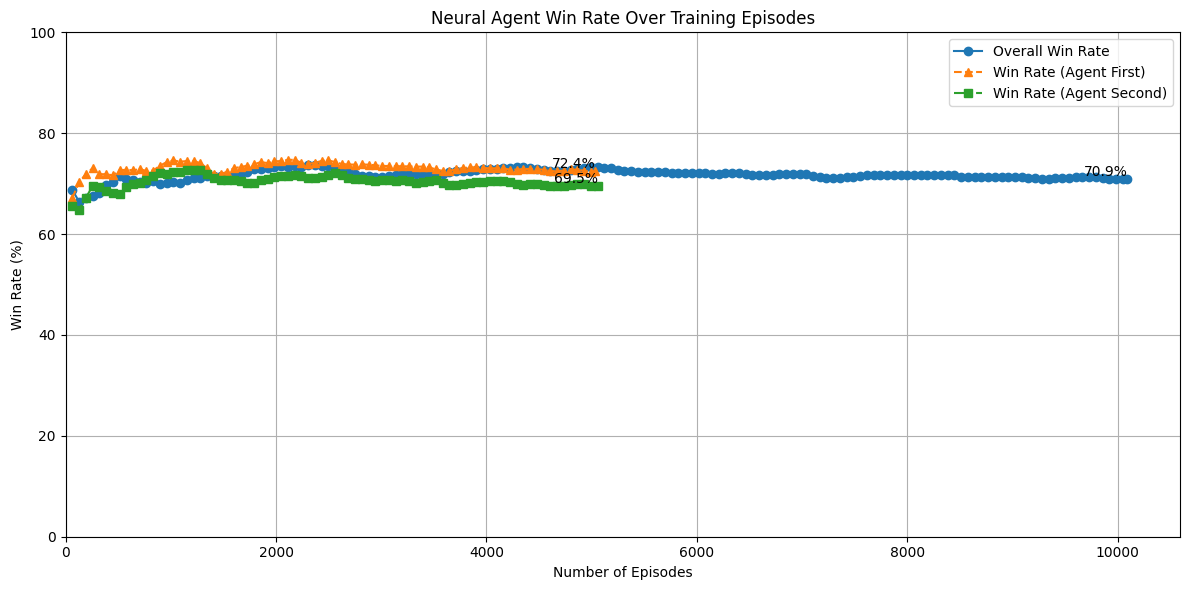

No action data to plot.


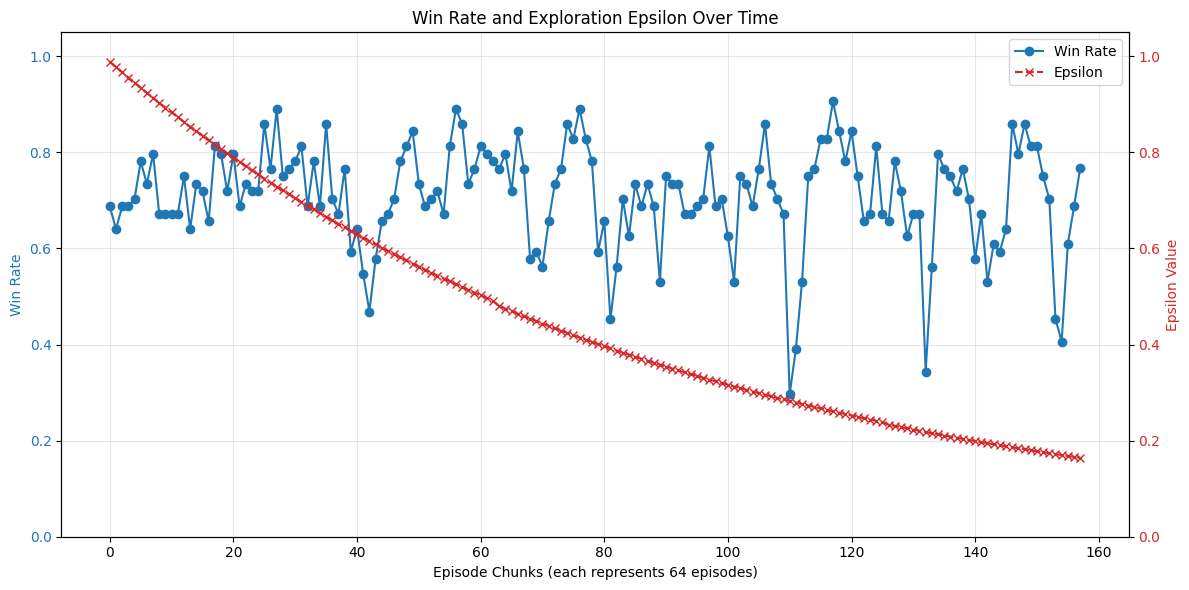


--- Analysis Summary ---
Total valid episodes analyzed: 10091
Overall Win Rate: 70.93%
Average steps per episode: 117.84
Median steps per episode: 115.0
Min steps per episode: 21
Max steps per episode: 418

--- Action Distribution ---
No action data recorded.
------------------------


In [12]:
from src.analysis.visualization import plot_win_rate_and_epsilon

if agent_memory:
    # Analyze win/loss outcomes, steps per episode, and action counts
    episode_outcomes, first_player_outcomes, second_player_outcomes, episode_steps, action_distribution = analyze_win_loss_and_steps(agent_memory['episodes'])

    if episode_outcomes:
        # Calculate win rate over time (e.g., in chunks of 100 episodes)
        chunk_size = agent_memory['batch_size']
        chunks, rates = calculate_win_rate_over_time(episode_outcomes, chunk_size)

        # Plot win rates by starting position (using existing function)
        analyze_and_plot_win_rates_by_starting_position(memory=agent_memory['episodes'], chunk_size=chunk_size)
        
        # Plot win rate with exploration epsilon (using our new function)
        # Epsilon parameters: starts at 0.995 and decays every 5 episodes
        plot_win_rate_and_epsilon(episode_outcomes, 
                                 chunk_size=chunk_size, 
                                 initial_epsilon=agent_memory['exploration_decay_rate'], 
                                 decay_interval=chunk_size)

        # Print overall summary
        overall_win_rate = np.mean(episode_outcomes) * 100
        print(f"\n--- Analysis Summary ---")
        print(f"Total valid episodes analyzed: {len(episode_outcomes)}")
        print(f"Overall Win Rate: {overall_win_rate:.2f}%")

        # Calculate and print step statistics
        if episode_steps:
            avg_steps = np.mean(episode_steps)
            median_steps = np.median(episode_steps)
            min_steps = np.min(episode_steps)
            max_steps = np.max(episode_steps)
            print(f"Average steps per episode: {avg_steps:.2f}")
            print(f"Median steps per episode: {median_steps}")
            print(f"Min steps per episode: {min_steps}")
            print(f"Max steps per episode: {max_steps}")
        else:
            print("No step data available for completed episodes.")

        # Print action distribution summary
        print("\n--- Action Distribution ---")
        if action_distribution:
            total_actions = sum(action_distribution.values())
            print(f"Total actions taken across all episodes: {total_actions}")
            # Sort actions by count for display
            sorted_actions = sorted(action_distribution.items(), key=lambda item: item[1], reverse=True)
            for action_type, count in sorted_actions:
                percentage = (count / total_actions) * 100 if total_actions > 0 else 0
                # Use ActionType.name if available
                action_name = action_type.name if hasattr(action_type, 'name') else str(action_type)
                print(f"- {action_name}: {count} ({percentage:.2f}%)")
        else:
            print("No action data recorded.")
        print(f"------------------------")

    else:
        print("No valid episode outcomes found to calculate statistics.")
else:
    print("Could not load memory or memory is empty.")
